http://blog.ayoungprogrammer.com/archive/

https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [175]:
import pandas as pd
import numpy as np
import itertools
import os
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [176]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [177]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [178]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0].str.lower()
    df['first2']= df['username'].str[:1]
    df['first3']= df['username'].str[:2]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    
pre0=pre1.copy()

add_features(pre0)

CPU times: user 502 ms, sys: 7 ms, total: 509 ms
Wall time: 1.02 s


In [179]:
pre0.head(10)

,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper
0,billion,male,n,on,ion,b,b,bi,7,0.428571,0.000000,False,False,False,False,0,0,False
2,ArmenSoft,male,t,ft,oft,a,A,Ar,9,0.222222,0.000000,False,False,False,False,0,2,True
3,okbookman,male,n,an,man,o,o,ok,9,0.444444,0.000000,False,True,False,False,0,0,False
4,revitupmedia,male,a,ia,dia,r,r,re,12,0.500000,0.000000,True,False,False,False,0,0,False
7,sakshiinfosys,male,s,ys,sys,s,s,sa,13,0.384615,0.000000,False,False,False,False,0,0,False
8,dreamdash,male,h,sh,ash,d,d,dr,9,0.333333,0.000000,False,False,False,False,0,0,False
10,a2ztranslate,male,e,te,ate,a,a,a2,12,0.333333,0.083333,True,True,False,False,1,0,False
11,sunsetsurf,male,f,rf,urf,s,s,su,10,0.300000,0.000000,False,False,False,False,0,0,False
12,Maven,male,n,en,ven,m,M,Ma,5,0.400000,0.000000,False,False,False,False,0,1,True
15,wwwsolutions,male,s,ns,ons,w,w,ww,12,0.333333,0.000000,False,False,False,False,0,0,False


In [180]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [181]:
print pre0.columns.values
print pre0.columns.values[2:8]
pre0.head()

['username' 'fname.gender' 'last' 'last_two' 'last_three' 'first' 'first2'
 'first3' 'nchar' 'vowels.pct' 'digits.pct' 'last_is_vowel'
 'first_is_vowel' 'last_is_digit' 'first_is_digit' 'digits.num' 'upper.pct'
 'first_is_upper']
['last' 'last_two' 'last_three' 'first' 'first2' 'first3']


,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper
0,billion,male,n,on,ion,b,b,bi,7,0.428571,0.0,False,False,False,False,0,0,False
2,ArmenSoft,male,t,ft,oft,a,A,Ar,9,0.222222,0.0,False,False,False,False,0,2,True
3,okbookman,male,n,an,man,o,o,ok,9,0.444444,0.0,False,True,False,False,0,0,False
4,revitupmedia,male,a,ia,dia,r,r,re,12,0.500000,0.0,True,False,False,False,0,0,False
7,sakshiinfosys,male,s,ys,sys,s,s,sa,13,0.384615,0.0,False,False,False,False,0,0,False


In [182]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:8]
label_encode(pre0, to_be_encoded_cols)


CPU times: user 131 ms, sys: 1e+03 µs, total: 132 ms
Wall time: 274 ms


In [183]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 16), (34482,), (14778, 16), (14778,)]


,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper
49013,55,1160,7304,21,47,1626,7,0.428571,0.0,False,True,False,False,0,0,False


In [184]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [185]:
%%time
fr=RandomForestClassifier(
#     n_estimators=150, min_samples_split=20
)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 1.22 s


0.785153606713
0.78826634186
Confusion matrix, without normalization
[[  368  2293]
 [  836 11281]]


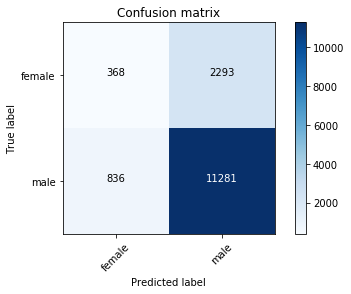

In [186]:
print (11258+345)/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.819258357017
Confusion matrix, without normalization
[[    1  2660]
 [   11 12106]]


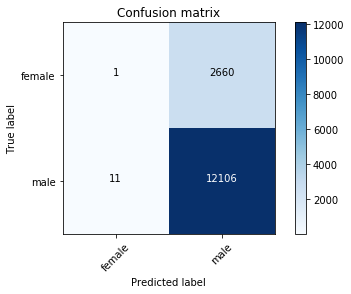

CPU times: user 5.05 s, sys: 414 ms, total: 5.46 s
Wall time: 10.5 s


In [187]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [188]:
import xgboost as xgb

In [189]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [190]:
d_train.get_label()

array([ 0.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [46]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.9,
#     'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 11,
    'subsample': 0.9,
    'alpha': 0.1,
    'lambda':0.9,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [47]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.828606	test-acc:0.808296
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.827707	test-acc:0.819529
[40]	train-acc:0.827997	test-acc:0.8198
[60]	train-acc:0.83052	test-acc:0.819867
[80]	train-acc:0.834696	test-acc:0.82007
[100]	train-acc:0.838263	test-acc:0.819597
[120]	train-acc:0.844122	test-acc:0.819529
[140]	train-acc:0.849255	test-acc:0.819123
[160]	train-acc:0.85404	test-acc:0.81892
Stopping. Best iteration:
[78]	train-acc:0.834174	test-acc:0.820206



'!!! used 24.43 s'

accuracy 0.818987684396
statistic
male      14614
female      164
dtype: int64
Confusion matrix, without normalization
[[   75  2586]
 [   89 12028]]


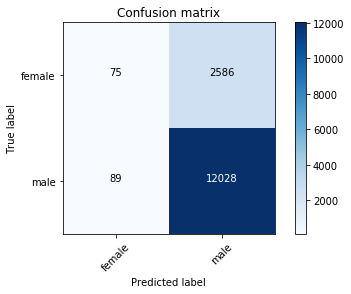

In [48]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [63]:
pre0.head(3)

,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,split_words
0,billion,male,49,1419,5594,1,27,1000,7,0.428571,0.0,False,False,False,False,0,0,False,[billion]
2,ArmenSoft,male,56,1034,7740,0,0,43,9,0.222222,0.0,False,False,False,False,0,2,True,"[armen, soft]"
3,okbookman,male,49,816,6707,15,41,1437,9,0.444444,0.0,False,True,False,False,0,0,False,"[ok, book, man]"


In [50]:
pre0['split_words']=pre0['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

http://blog.ayoungprogrammer.com/2016/04/determining-gender-of-name-with-80.html/

In [51]:
from genderizer.genderizer import Genderizer

In [114]:
['a','b'].count('g')

0

In [165]:
def helper(X):
    tmp = list(map(Genderizer.detect, X))
    tmp = [i for i in tmp if i!=None]
    try:
        tmp[0]
        if len(tmp)>1:
            m=tmp.count('male')
            f=tmp.count('female')
            if f>m:
                return 'female'
            else:
                return 'male'
        else:
#             return tmp[0]
            return 'male'
    except:
        return 

In [166]:
pre0['split_words'].apply(helper).value_counts()

male      19330
female      228
Name: split_words, dtype: int64

In [167]:
pre0['username_split_predict'] = pre0['split_words'].apply(helper)

In [168]:
pre0['username_split_predict'].fillna('male').value_counts()

male      49032
female      228
Name: username_split_predict, dtype: int64

In [169]:
pre0['pre_model_pred'] = pre0['username_split_predict'].fillna('male')

In [170]:
accuracy_score(pre0['fname.gender'], pre0['pre_model_pred'])

0.81938692651238332

Confusion matrix, without normalization
[[  101  8770]
 [  127 40262]]


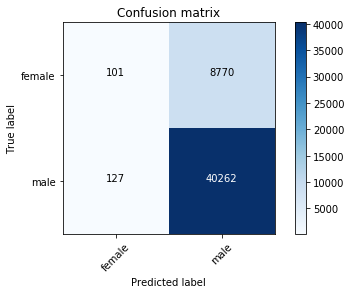

In [171]:
plot_confusion_matrix(confusion_matrix(pre0['fname.gender'], pre0['pre_model_pred']),classes=['female','male'])

In [172]:
test = df.iloc[X_test.index]['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower())).apply(helper)

In [173]:
accuracy_score(y_test, test.fillna('male'))

0.81932602517255382

Confusion matrix, without normalization
[[   33  2628]
 [   42 12075]]


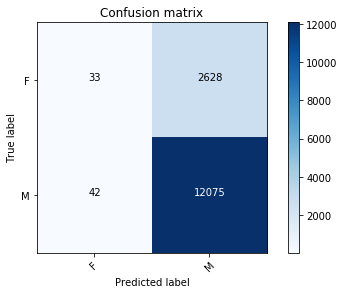

In [174]:
plot_confusion_matrix(confusion_matrix(y_test, test.fillna('male')), ['F','M'])

### other sklearn models

In [270]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()